# Face Recognition

In [163]:
import pandas as pd
import base64
import numpy as np
from PIL import Image
import io
import cv2 as cv2
from io import BytesIO
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import random as rand
from scipy import io as sp
import dlib
import os
import itertools as it
import pixiedust
colors = sns.color_palette()

### Load celebrity name data

In [28]:
celebName = pd.read_csv('Top1M_MidList.Name.tsv',names=['Id','Name'], delimiter='\t', error_bad_lines=False)
language = celebName['Name'].str.split("@", n=1, expand=True)
celebName['Name'] = language[0]
celebName['Language'] = language[1]
celebName = celebName[celebName['Language'] == 'en']
celebName.drop(columns=['Language'], inplace=True)

### Load celebrity images

In [29]:
clebs = pd.read_csv('images.tsv', delimiter="\t", engine='python', error_bad_lines=False)

### Join on id

In [30]:
clebs = clebs.merge(celebName, how='left', left_on='Id', right_on='Id')
del celebName

In [31]:
clebs.head()

,Id,Image,Name
0,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
1,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
2,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
3,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon
4,m.0169dl,/9j/4AAQSkZJRgABAQEAYABgAAD/2wBDAAQCAwMDAgQDAw...,Matt Damon


### Data distribution

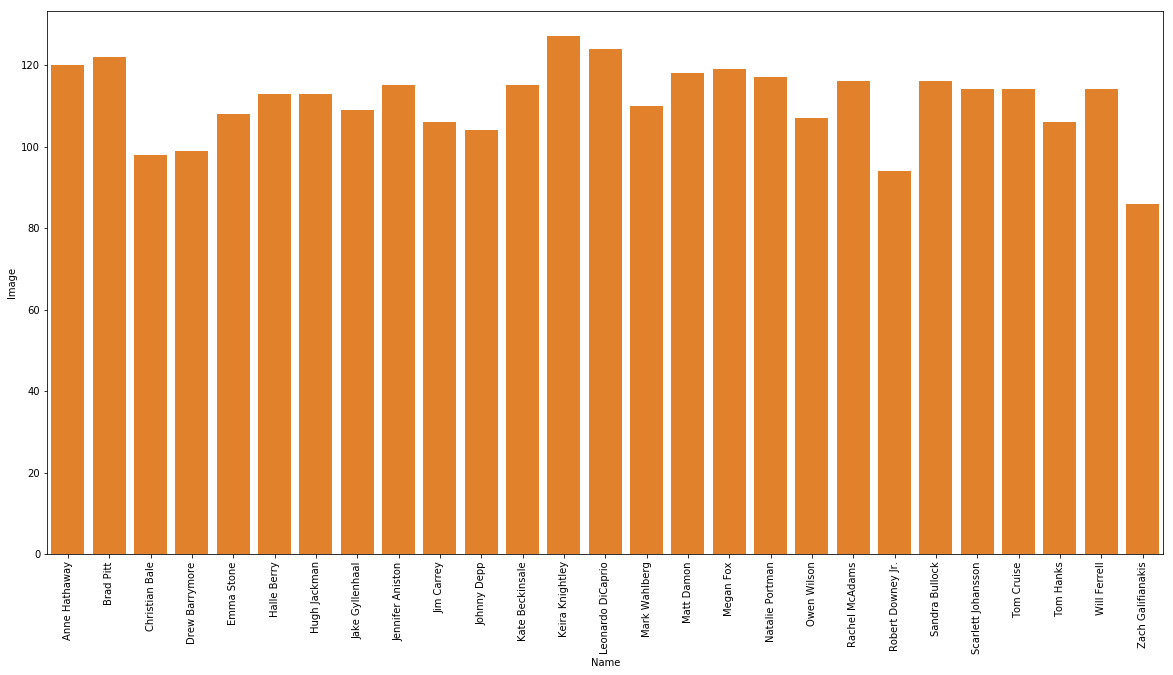

In [6]:
celebCount = clebs.groupby(['Name']).count().reset_index()
plt.figure(figsize=(20,10))
plt.xticks(rotation=90)
sns.barplot(x='Name', y='Image', data=celebCount, color = colors[1])
plt.show()

In [7]:
def get_image(base64Image, display=True):
    img = Image.open(BytesIO(base64.b64decode(base64Image))).convert('RGB') 
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(img)
    return img
#   to open image in new window
#   img.show()

def get_opencv2_image(base64Image, display=False):
    return cv2.cvtColor(np.array(get_image(base64Image, display)), cv2.COLOR_RGB2BGR)

def convertToRGB(opencv2_image):
    return cv2.cvtColor(opencv2_image, cv2.COLOR_BGR2RGB)

# TODO

In [8]:
def rect_to_cordinate(rect):
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    return (x, y, w, h)

In [9]:
def detect_faces(test_image, display=True, scaleFactor = 1):
    face_detector = dlib.get_frontal_face_detector()
    faces_rect = face_detector(test_image, 1)
    
    if display:
        image_copy = test_image.copy()
        for rect in faces_rect:
            (x,y,w,h) = rect_to_cordinate(rect)
            cv2.rectangle(image_copy, (x,y), (x+w, y+h), (0,255,255), 2)
    
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(convertToRGB(image_copy))
    
    return faces_rect

In [10]:
def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
 
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
 
    # return the list of (x, y)-coordinates
    return coords

In [11]:
def detect_landmarks(image, faces, display=True):
    pose_landmarks = None
    face_pose_predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")
    
    if display:
        test_copy = image.copy()
    
    for face in faces:
        pose_landmarks = face_pose_predictor(image, face)
        if display:
            for (x, y) in shape_to_np(pose_landmarks):
                cv2.circle(test_copy, (x, y), 1, (0,0,255), -1)
    if display:
        plt.figure(figsize=(8,8))
        plt.imshow(convertToRGB(test_copy))
    
    return pose_landmarks

In [12]:
def scale_face(image, landmarks, display=True):
    fod = dlib.full_object_detections()
    fod.append(landmarks)
    img = dlib.get_face_chips(image, fod, size=128)
    if display:
        for x in img:
            plt.figure(figsize=(8,8))
            plt.imshow(convertToRGB(x))
    return img

In [132]:
def get_scaled(base64image,display=False):
    img_raw = get_opencv2_image(base64image)
    faces = detect_faces(img_raw,display=False)
    if not faces:
        return np.nan
    landmarks = detect_landmarks(img_raw, faces,display=False)
    scaleimg = scale_face(img_raw, landmarks, display=display)
    return scaleimg[0]


### Detect Faces

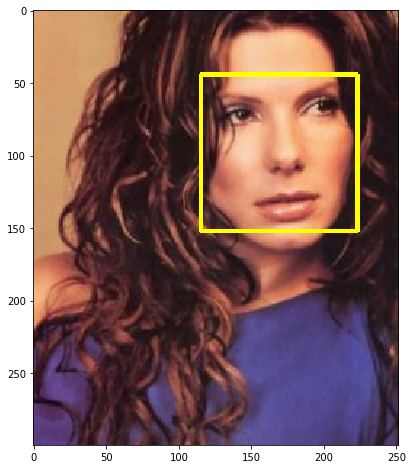

In [14]:
i = rand.randrange(0,len(clebs))
base64image = clebs.iloc[i]['Image']
img_raw = get_opencv2_image(base64image)
faces = detect_faces(img_raw)

## Dectect landmarks

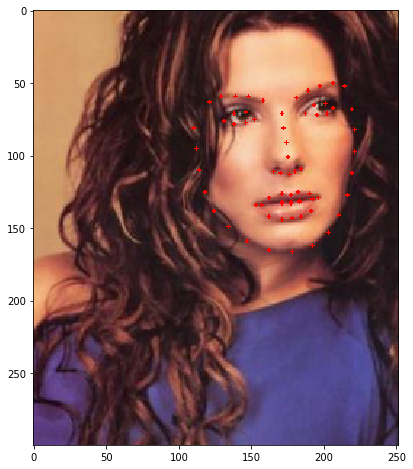

In [15]:
landmarks = detect_landmarks(img_raw, faces)

# Scale And Align Images

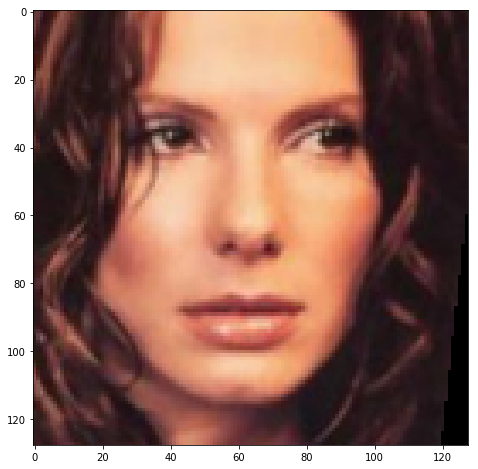

In [16]:
scaleimg = scale_face(img_raw, landmarks, display=True)

In [137]:
n = len(clebs)
for i in range(n):
    print('Progess [{}/{}]'.format(i,n))
    if rand.randint(0,10) > 6:
        clebs.iloc[i]['Image'] = get_scaled(clebs.iloc[i]['Image'], display=False)
    else:
        clebs.iloc[i]['Image'] = np.nan
clebs.dropna(inplace=True)
np.save('scaled_subset', clebs.values)

Progess [0/3003]
Progess [1/3003]
Progess [2/3003]
Progess [3/3003]
Progess [4/3003]
Progess [5/3003]
Progess [6/3003]
Progess [7/3003]
Progess [8/3003]
Progess [9/3003]
Progess [10/3003]
Progess [11/3003]
Progess [12/3003]
Progess [13/3003]
Progess [14/3003]
Progess [15/3003]
Progess [16/3003]
Progess [17/3003]
Progess [18/3003]
Progess [19/3003]
Progess [20/3003]
Progess [21/3003]
Progess [22/3003]
Progess [23/3003]
Progess [24/3003]
Progess [25/3003]
Progess [26/3003]
Progess [27/3003]
Progess [28/3003]
Progess [29/3003]
Progess [30/3003]
Progess [31/3003]
Progess [32/3003]
Progess [33/3003]
Progess [34/3003]
Progess [35/3003]
Progess [36/3003]
Progess [37/3003]
Progess [38/3003]
Progess [39/3003]
Progess [40/3003]
Progess [41/3003]
Progess [42/3003]
Progess [43/3003]
Progess [44/3003]
Progess [45/3003]
Progess [46/3003]
Progess [47/3003]
Progess [48/3003]
Progess [49/3003]
Progess [50/3003]
Progess [51/3003]
Progess [52/3003]
Progess [53/3003]
Progess [54/3003]
Progess [55/3003]
Pr

Progess [437/3003]
Progess [438/3003]
Progess [439/3003]
Progess [440/3003]
Progess [441/3003]
Progess [442/3003]
Progess [443/3003]
Progess [444/3003]
Progess [445/3003]
Progess [446/3003]
Progess [447/3003]
Progess [448/3003]
Progess [449/3003]
Progess [450/3003]
Progess [451/3003]
Progess [452/3003]
Progess [453/3003]
Progess [454/3003]
Progess [455/3003]
Progess [456/3003]
Progess [457/3003]
Progess [458/3003]
Progess [459/3003]
Progess [460/3003]
Progess [461/3003]
Progess [462/3003]
Progess [463/3003]
Progess [464/3003]
Progess [465/3003]
Progess [466/3003]
Progess [467/3003]
Progess [468/3003]
Progess [469/3003]
Progess [470/3003]
Progess [471/3003]
Progess [472/3003]
Progess [473/3003]
Progess [474/3003]
Progess [475/3003]
Progess [476/3003]
Progess [477/3003]
Progess [478/3003]
Progess [479/3003]
Progess [480/3003]
Progess [481/3003]
Progess [482/3003]
Progess [483/3003]
Progess [484/3003]
Progess [485/3003]
Progess [486/3003]
Progess [487/3003]
Progess [488/3003]
Progess [489

Progess [869/3003]
Progess [870/3003]
Progess [871/3003]
Progess [872/3003]
Progess [873/3003]
Progess [874/3003]
Progess [875/3003]
Progess [876/3003]
Progess [877/3003]
Progess [878/3003]
Progess [879/3003]
Progess [880/3003]
Progess [881/3003]
Progess [882/3003]
Progess [883/3003]
Progess [884/3003]
Progess [885/3003]
Progess [886/3003]
Progess [887/3003]
Progess [888/3003]
Progess [889/3003]
Progess [890/3003]
Progess [891/3003]
Progess [892/3003]
Progess [893/3003]
Progess [894/3003]
Progess [895/3003]
Progess [896/3003]
Progess [897/3003]
Progess [898/3003]
Progess [899/3003]
Progess [900/3003]
Progess [901/3003]
Progess [902/3003]
Progess [903/3003]
Progess [904/3003]
Progess [905/3003]
Progess [906/3003]
Progess [907/3003]
Progess [908/3003]
Progess [909/3003]
Progess [910/3003]
Progess [911/3003]
Progess [912/3003]
Progess [913/3003]
Progess [914/3003]
Progess [915/3003]
Progess [916/3003]
Progess [917/3003]
Progess [918/3003]
Progess [919/3003]
Progess [920/3003]
Progess [921

Progess [1291/3003]
Progess [1292/3003]
Progess [1293/3003]
Progess [1294/3003]
Progess [1295/3003]
Progess [1296/3003]
Progess [1297/3003]
Progess [1298/3003]
Progess [1299/3003]
Progess [1300/3003]
Progess [1301/3003]
Progess [1302/3003]
Progess [1303/3003]
Progess [1304/3003]
Progess [1305/3003]
Progess [1306/3003]
Progess [1307/3003]
Progess [1308/3003]
Progess [1309/3003]
Progess [1310/3003]
Progess [1311/3003]
Progess [1312/3003]
Progess [1313/3003]
Progess [1314/3003]
Progess [1315/3003]
Progess [1316/3003]
Progess [1317/3003]
Progess [1318/3003]
Progess [1319/3003]
Progess [1320/3003]
Progess [1321/3003]
Progess [1322/3003]
Progess [1323/3003]
Progess [1324/3003]
Progess [1325/3003]
Progess [1326/3003]
Progess [1327/3003]
Progess [1328/3003]
Progess [1329/3003]
Progess [1330/3003]
Progess [1331/3003]
Progess [1332/3003]
Progess [1333/3003]
Progess [1334/3003]
Progess [1335/3003]
Progess [1336/3003]
Progess [1337/3003]
Progess [1338/3003]
Progess [1339/3003]
Progess [1340/3003]


Progess [1705/3003]
Progess [1706/3003]
Progess [1707/3003]
Progess [1708/3003]
Progess [1709/3003]
Progess [1710/3003]
Progess [1711/3003]
Progess [1712/3003]
Progess [1713/3003]
Progess [1714/3003]
Progess [1715/3003]
Progess [1716/3003]
Progess [1717/3003]
Progess [1718/3003]
Progess [1719/3003]
Progess [1720/3003]
Progess [1721/3003]
Progess [1722/3003]
Progess [1723/3003]
Progess [1724/3003]
Progess [1725/3003]
Progess [1726/3003]
Progess [1727/3003]
Progess [1728/3003]
Progess [1729/3003]
Progess [1730/3003]
Progess [1731/3003]
Progess [1732/3003]
Progess [1733/3003]
Progess [1734/3003]
Progess [1735/3003]
Progess [1736/3003]
Progess [1737/3003]
Progess [1738/3003]
Progess [1739/3003]
Progess [1740/3003]
Progess [1741/3003]
Progess [1742/3003]
Progess [1743/3003]
Progess [1744/3003]
Progess [1745/3003]
Progess [1746/3003]
Progess [1747/3003]
Progess [1748/3003]
Progess [1749/3003]
Progess [1750/3003]
Progess [1751/3003]
Progess [1752/3003]
Progess [1753/3003]
Progess [1754/3003]


Progess [2116/3003]
Progess [2117/3003]
Progess [2118/3003]
Progess [2119/3003]
Progess [2120/3003]
Progess [2121/3003]
Progess [2122/3003]
Progess [2123/3003]
Progess [2124/3003]
Progess [2125/3003]
Progess [2126/3003]
Progess [2127/3003]
Progess [2128/3003]
Progess [2129/3003]
Progess [2130/3003]
Progess [2131/3003]
Progess [2132/3003]
Progess [2133/3003]
Progess [2134/3003]
Progess [2135/3003]
Progess [2136/3003]
Progess [2137/3003]
Progess [2138/3003]
Progess [2139/3003]
Progess [2140/3003]
Progess [2141/3003]
Progess [2142/3003]
Progess [2143/3003]
Progess [2144/3003]
Progess [2145/3003]
Progess [2146/3003]
Progess [2147/3003]
Progess [2148/3003]
Progess [2149/3003]
Progess [2150/3003]
Progess [2151/3003]
Progess [2152/3003]
Progess [2153/3003]
Progess [2154/3003]
Progess [2155/3003]
Progess [2156/3003]
Progess [2157/3003]
Progess [2158/3003]
Progess [2159/3003]
Progess [2160/3003]
Progess [2161/3003]
Progess [2162/3003]
Progess [2163/3003]
Progess [2164/3003]
Progess [2165/3003]


Progess [2528/3003]
Progess [2529/3003]
Progess [2530/3003]
Progess [2531/3003]
Progess [2532/3003]
Progess [2533/3003]
Progess [2534/3003]
Progess [2535/3003]
Progess [2536/3003]
Progess [2537/3003]
Progess [2538/3003]
Progess [2539/3003]
Progess [2540/3003]
Progess [2541/3003]
Progess [2542/3003]
Progess [2543/3003]
Progess [2544/3003]
Progess [2545/3003]
Progess [2546/3003]
Progess [2547/3003]
Progess [2548/3003]
Progess [2549/3003]
Progess [2550/3003]
Progess [2551/3003]
Progess [2552/3003]
Progess [2553/3003]
Progess [2554/3003]
Progess [2555/3003]
Progess [2556/3003]
Progess [2557/3003]
Progess [2558/3003]
Progess [2559/3003]
Progess [2560/3003]
Progess [2561/3003]
Progess [2562/3003]
Progess [2563/3003]
Progess [2564/3003]
Progess [2565/3003]
Progess [2566/3003]
Progess [2567/3003]
Progess [2568/3003]
Progess [2569/3003]
Progess [2570/3003]
Progess [2571/3003]
Progess [2572/3003]
Progess [2573/3003]
Progess [2574/3003]
Progess [2575/3003]
Progess [2576/3003]
Progess [2577/3003]


Progess [2940/3003]
Progess [2941/3003]
Progess [2942/3003]
Progess [2943/3003]
Progess [2944/3003]
Progess [2945/3003]
Progess [2946/3003]
Progess [2947/3003]
Progess [2948/3003]
Progess [2949/3003]
Progess [2950/3003]
Progess [2951/3003]
Progess [2952/3003]
Progess [2953/3003]
Progess [2954/3003]
Progess [2955/3003]
Progess [2956/3003]
Progess [2957/3003]
Progess [2958/3003]
Progess [2959/3003]
Progess [2960/3003]
Progess [2961/3003]
Progess [2962/3003]
Progess [2963/3003]
Progess [2964/3003]
Progess [2965/3003]
Progess [2966/3003]
Progess [2967/3003]
Progess [2968/3003]
Progess [2969/3003]
Progess [2970/3003]
Progess [2971/3003]
Progess [2972/3003]
Progess [2973/3003]
Progess [2974/3003]
Progess [2975/3003]
Progess [2976/3003]
Progess [2977/3003]
Progess [2978/3003]
Progess [2979/3003]
Progess [2980/3003]
Progess [2981/3003]
Progess [2982/3003]
Progess [2983/3003]
Progess [2984/3003]
Progess [2985/3003]
Progess [2986/3003]
Progess [2987/3003]
Progess [2988/3003]
Progess [2989/3003]


In [333]:
dataset = np.load('scaled_subset.npy')
labels = np.unique(dataset.T[:][2])
x_positive = []
x_negative = []

positive_sample_size = 1
negative_sample_size = 0.01
for l in labels:
    combos_positive = list(it.combinations(dataset[np.where(dataset.T[:][2] == l)], 2))
    index = np.arange(len(combos_positive))
    np.random.shuffle(index)
    index = index[: int(len(combos_positive)*positive_sample_size)]
    x_positive += [combos_positive[j] for j in index]
    
    combos_negative = list(it.combinations(dataset[np.where(dataset.T[:][2] != l)], 2))
    index = np.arange(len(combos_negative))
    np.random.shuffle(index)
    index = index[: int(len(combos_negative)*negative_sample_size)]
    x_negative += [combos_negative[j] for j in index]

X = np.vstack((np.asarray(x_positive), np.asarray(x_negative)))
y = np.vstack((np.full((len(x_positive),1),0), np.full((len(x_negative),1),1)))
print(X.shape)
print(y.shape)
dt = {}
dt['X'] = X
dt['y'] = y

(163254, 2, 3)
(163254, 1)


In [ ]:
sp.savemat('dataset', dt, do_compression=True)

In [331]:
xx = np.load('labels.npy')
yy = np.load('dataset.npy')

In [332]:
xx.shape

(163254, 1)